In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:

from google.colab import files
import io
uploaded = files.upload()
stf = pd.read_csv(io.BytesIO(uploaded['reviews.csv']))
print(stf)

Saving reviews.csv to reviews (1).csv
            Time_submitted                                             Review  \
0      2022-07-09 15:00:00  Great music service, the audio is high quality...   
1      2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2      2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3      2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4      2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   
...                    ...                                                ...   
61589  2022-01-01 03:01:29  Even though it was communicated that lyrics fe...   
61590  2022-01-01 02:13:40  Use to be sooo good back when I had it, and wh...   
61591  2022-01-01 01:02:29  This app would be good if not for it taking ov...   
61592  2022-01-01 00:49:23  The app is good hard to navigate and won't jus...   
61593  2022-01-01 00:19:09  Its good but sometimes it doesnt load the m

In [4]:
import gensim
from gensim.parsing.preprocessing import strip_non_alphanum, strip_multiple_whitespaces, preprocess_string, split_alphanum, strip_short, strip_numeric
import re 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
def lower_case(docs):
  return [doc.lower() for doc in docs]

def remove_punc(docs):
  # Loai bo dau cau & ki tu dac biet
  return [strip_non_alphanum(doc).strip() for doc in docs]

def separate_num(docs):
  # Tach cac so va chu lien nhau
  return [split_alphanum(doc) for doc in docs]

def remove_one_letter_word(docs):
  return [strip_short(doc) for doc in docs]

def remove_number(docs):
  return [strip_numeric(doc) for doc in docs]

def replace_multiple_whitespaces(docs):
  # Thay the nhieu spaces bang mot space
  return [strip_multiple_whitespaces(doc) for doc in docs]

def remove_stopwords(docs):
    return [" ".join([word for word in doc.split() if word not in stop_words]) for doc in docs]

doc = lower_case(stf['Review'])
doc = remove_punc(doc)
doc = separate_num(doc)
doc = remove_one_letter_word(doc)
doc = remove_number(doc)
doc = replace_multiple_whitespaces(doc)
doc = remove_stopwords(doc)

stf['Review'] = doc

In [6]:
stf1 = stf.copy()
rate = [1,2,3,4,5]
sentiment = [0, 0, 1, 1, 1]
for i in range(5):
    stf1["Rating"].replace(rate[i], sentiment[i],inplace=True)

In [61]:
stf1.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,great music service audio high quality app eas...,1,2,NaN
1,2022-07-09 14:21:22,please ignore previous negative rating app sup...,1,1,NaN
2,2022-07-09 13:27:32,pop get best spotify experience android annoyi...,1,0,NaN
3,2022-07-09 13:26:45,really buggy terrible use recently,0,1,NaN
4,2022-07-09 13:20:49,dear spotify get songs put playlist shuffle play,0,1,NaN


## Setup

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Transformer block as a layer

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [10]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Prepare dataset

In [62]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train, x_test, y_train, y_test = train_test_split(stf1['Review'], stf1['Rating'], test_size=0.2, random_state=42)
print(x_train[0])

# Tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
print(x_train[0:1])
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
print(x_train[0])

# Pad the sequences to make all inputs the same length
max_length = max([len(s) for s in x_train])
print(max_length)

x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')

x_val, y_val = x_train[:10000], y_train[:10000]
x_train_, y_train_ = x_train[10000:], y_train[10000:]

great music service audio high quality app easy use also quick friendly support
3305    man spotify great know put covid warning appro...
Name: Review, dtype: object
[816, 3, 13, 71, 162, 1062, 1418, 2717, 516, 317, 285, 61]
311


In [63]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = max_length  # Only consider the first 200 words of each movie review
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

49275 Training sequences
10000 Validation sequences


## Create model 

In [32]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [29]:
print(x_train[0])

[ 816    3   13   71  162 1062 1418 2717  516  317  285   61    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

## Train and Evaluate

In [35]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val)
)

Epoch 1/20
1540/1540 [==============================] - 43s 25ms/step - loss: 0.2692 - accuracy: 0.8812 - val_loss: 0.2483 - val_accuracy: 0.8992
Epoch 2/20
1540/1540 [==============================] - 21s 13ms/step - loss: 0.2541 - accuracy: 0.8875 - val_loss: 0.2137 - val_accuracy: 0.9071
Epoch 3/20
1540/1540 [==============================] - 21s 14ms/step - loss: 0.2371 - accuracy: 0.8944 - val_loss: 0.2053 - val_accuracy: 0.9081
Epoch 4/20
1540/1540 [==============================] - 20s 13ms/step - loss: 0.2252 - accuracy: 0.8992 - val_loss: 0.1904 - val_accuracy: 0.9156
Epoch 5/20
1540/1540 [==============================] - 19s 12ms/step - loss: 0.2140 - accuracy: 0.9027 - val_loss: 0.1923 - val_accuracy: 0.9143
Epoch 6/20
1540/1540 [==============================] - 20s 13ms/step - loss: 0.2046 - accuracy: 0.9061 - val_loss: 0.1800 - val_accuracy: 0.9177
Epoch 7/20
1540/1540 [==============================] - 20s 13ms/step - loss: 0.1971 - accuracy: 0.9080 - val_loss: 0.1760 -

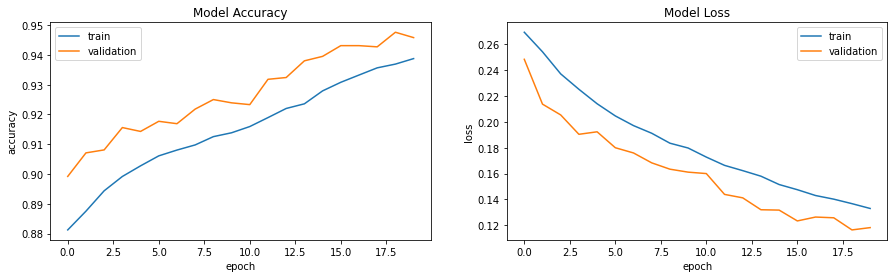

In [36]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
 
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)

In [37]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 311)]             0         
                                                                 
 token_and_position_embeddin  (None, 311, 32)          649952    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, 311, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 32)                0   

Epoch 1/30
770/770 [==============================] - 45s 54ms/step - loss: 0.1248 - accuracy: 0.9439 - val_loss: 0.1086 - val_accuracy: 0.9535
Epoch 2/30
770/770 [==============================] - 15s 20ms/step - loss: 0.1184 - accuracy: 0.9458 - val_loss: 0.1043 - val_accuracy: 0.9555
Epoch 3/30
770/770 [==============================] - 14s 18ms/step - loss: 0.1160 - accuracy: 0.9465 - val_loss: 0.1060 - val_accuracy: 0.9526
Epoch 4/30
770/770 [==============================] - 14s 18ms/step - loss: 0.1145 - accuracy: 0.9485 - val_loss: 0.0998 - val_accuracy: 0.9577
Epoch 5/30
770/770 [==============================] - 14s 18ms/step - loss: 0.1109 - accuracy: 0.9498 - val_loss: 0.0993 - val_accuracy: 0.9572
Epoch 6/30
770/770 [==============================] - 13s 17ms/step - loss: 0.1083 - accuracy: 0.9508 - val_loss: 0.0983 - val_accuracy: 0.9566
Epoch 7/30
770/770 [==============================] - 14s 18ms/step - loss: 0.1063 - accuracy: 0.9529 - val_loss: 0.0922 - val_accuracy:

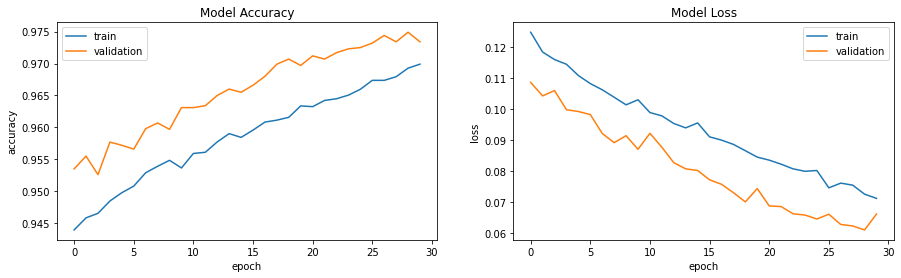

In [38]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=64, epochs=30, verbose=1, validation_data=(x_val, y_val)
)

plot_training_hist(history)

In [42]:
print("Transformer Score---> ", model.evaluate(x_test, y_test, verbose=0))

Transformer Score--->  [1.8238563537597656, 0.7762805223464966]
